Imports

In [2]:
import os
import json
import pandas as pd
import re
import requests
import zipfile
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import arabic_reshaper

In [3]:
from camel_tools.morphology.database import MorphologyDB
from camel_tools.morphology.analyzer import Analyzer
from camel_tools.utils.dediac import dediac_ar
from camel_tools.tokenizers.word import simple_word_tokenize

In [4]:
%pip install git+https://github.com/CAMeL-Lab/camel_tools.git

Note: you may need to restart the kernel to use updated packages.Collecting git+https://github.com/CAMeL-Lab/camel_tools.git
  Cloning https://github.com/CAMeL-Lab/camel_tools.git to c:\users\youst\appdata\local\temp\pip-req-build-741k9ys1
  Resolved https://github.com/CAMeL-Lab/camel_tools.git to commit 7587192c01bed7e93a9ad0403881534aa30c07ee
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'



  Running command git clone --filter=blob:none --quiet https://github.com/CAMeL-Lab/camel_tools.git 'C:\Users\youst\AppData\Local\Temp\pip-req-build-741k9ys1'

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
url = "https://github.com/CAMeL-Lab/camel-tools-data/releases/download/2022.03.21/morphology_db_calima-msa-r13-0.4.0.zip"

target_dir = os.path.join(os.getenv("APPDATA"), "camel_tools", "data", "morphology_db", "calima-msa-r13")

os.makedirs(target_dir, exist_ok=True)

zip_path = os.path.join(target_dir, "morphology_db_calima-msa-r13.zip")

response = requests.get(url)
with open(zip_path, "wb") as f:
    f.write(response.content)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(target_dir)

os.remove(zip_path)

print("Morphology database downloaded and extracted successfully.")

Morphology database downloaded and extracted successfully.


In [6]:
%pip install python-bidi arabic-reshaper


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Dataframe Creation

In [7]:
transcription_folder = "data/rawdata/rawdata"
metadata_folder = "data/metadata/metadata"

transcription_files = sorted(os.listdir(transcription_folder))
metadata_files = sorted(os.listdir(metadata_folder))

data = []

for txt_file, json_file in zip(transcription_files, metadata_files):
    txt_path = os.path.join(transcription_folder, txt_file)
    json_path = os.path.join(metadata_folder, json_file)

    with open(txt_path, "r", encoding="utf-8") as f:
        transcription = f.read().strip()

    with open(json_path, "r", encoding="utf-8") as f:
        metadata = json.load(f)

    episode_data = {
        "title": metadata.get("title", "Unknown"),
        "author": metadata.get("author", "Unknown"),
        "categories": ", ".join(metadata.get("categories", [])), 
        "keywords": ", ".join(metadata.get("keywords", [])),  
        "source": metadata.get("source_url", "Unknown"),
        "publish_date": metadata.get("publish_date", "Unknown"),
        "length": metadata.get("length", "Unknown"),
        "type": metadata.get("type", "Unknown"),
        "transcription": transcription
    }

    data.append(episode_data)

df = pd.DataFrame(data)

df.head()

,title,author,categories,keywords,source,publish_date,length,type,transcription
0,5 نصائح للصحة النفسية في رمضان | برنامج سُكُو...,Kareem Esmail,Education,,https://youtube.com/watch?v=3tgiW4bQoJo,2024-03-11T00:00:00Z,00:08:11,Youtube,كل سنه وانت طيب ورمضان كريم وكل سنه في\nرمضان ...
1,7 عبادات سهلة تنقذ رمضان | برنامج سُكُون مع كريم,Kareem Esmail,Education,,https://youtube.com/watch?v=JHXrZBgf-yY,2024-03-18T00:00:00Z,00:07:38,Youtube,واحده من الحاجات اللطيفه في رمضان ان انت\nتجمع...
2,أكبر كذبة في التاريخ | وهم الانتاجية! - | بودك...,Kareem Esmail,Education,,https://youtube.com/watch?v=KiIDDLc-HfE,2023-10-06T00:00:00Z,00:29:20,Youtube,النهارده الفيديو بتاعنا على\nالانتاجيه لان الن...
3,أهم مهارة للنجاح | برنامج سُكُون مع كريم,Kareem Esmail,Education,,https://youtube.com/watch?v=J7yQ_AiWZwM,2024-03-21T00:00:00Z,00:14:37,Youtube,رغم ان عندي تعليقات كتيره جدا على قصص\nالنجاح ...
4,إزاي ضاعفت دخلي بدون شغل إضافي! - عن الرزق ووس...,Kareem Esmail,Education,,https://youtube.com/watch?v=qtlL5jEERXQ,2023-11-27T00:00:00Z,00:29:45,Youtube,انا النهارده جاي اقوللك ازاي تزود من\nدخلك الم...


### Data Preprocessing

Chunking

In [8]:
def chunk_by_lines(text, chunk_size=3):
    lines = text.split("\n")
    return [" ".join(lines[i:i+chunk_size]) for i in range(0, len(lines), chunk_size)]

df["chunks"] = df["transcription"].apply(lambda x: chunk_by_lines(x, chunk_size=3)) 

df = df.explode("chunks")

print(df.head())

                                               title         author  \
0  5 نصائح للصحة النفسية في رمضان | برنامج سُكُو...  Kareem Esmail   
0  5 نصائح للصحة النفسية في رمضان | برنامج سُكُو...  Kareem Esmail   
0  5 نصائح للصحة النفسية في رمضان | برنامج سُكُو...  Kareem Esmail   
0  5 نصائح للصحة النفسية في رمضان | برنامج سُكُو...  Kareem Esmail   
0  5 نصائح للصحة النفسية في رمضان | برنامج سُكُو...  Kareem Esmail   

  categories keywords                                   source  \
0  Education           https://youtube.com/watch?v=3tgiW4bQoJo   
0  Education           https://youtube.com/watch?v=3tgiW4bQoJo   
0  Education           https://youtube.com/watch?v=3tgiW4bQoJo   
0  Education           https://youtube.com/watch?v=3tgiW4bQoJo   
0  Education           https://youtube.com/watch?v=3tgiW4bQoJo   

           publish_date    length     type  \
0  2024-03-11T00:00:00Z  00:08:11  Youtube   
0  2024-03-11T00:00:00Z  00:08:11  Youtube   
0  2024-03-11T00:00:00Z  00:08:11  You

In [9]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["chunks"])  
num_clusters = 7 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df["chunk_cluster"] = kmeans.fit_predict(X)
df = df.explode("chunks")  
df = df.dropna(subset=["chunks"])  

print(df["chunks"].head())

0    كل سنه وانت طيب ورمضان كريم وكل سنه في رمضان ب...
0    يكرمنا واحده من اهم النصائح اللي ممكن تفرق معا...
0    وما تقعدش تسخن عليا وتقول لي يا كريم دخل الصحه...
0    كنت نفسيا منكسر فيها وهمدان ومتضايق ومكسور قو ...
0    والذنوب عامله زي ده هو الشيطان لما بيصدق يلاقي...
Name: chunks, dtype: object


In [10]:
for i in range(num_clusters):
    print(f"\n Cluster {i}")
    print(df[df["chunk_cluster"] == i]["chunks"].head(5).tolist())


 Cluster 0
['طيبه مستحضر نيه التغيير وتوكل على الله سبحانه وتعالى واستعين بيه وباذن الله رمضان ده يكون رمضان مختلف الله سبحانه', 'وتعالى يرزقك فيه انك تترقى في العباده وتترقى في الدنيا ويرزقك شويه دعاء يعني يستجاب كده باذن الله وحياتك كلها تبقى زي', 'سبحانه وتعالى ان يكون ليها اجر كبير من غير ما يبقى فيها مجهود كبير اول حاجه فيهم وهي الابتسامه حضرتك انت بس اقفل', 'لو مصروفك حطيت منه جزء صدقه والله العظيم وده مش وعدي الشخصي ده هو وعد الله سبحانه وتعالى للمتصدقين انت شوف البركه والرزق', 'بالزوجه ده حاجه جميل جدا وعليها ثواب واجر والله سبحانه وتعالى ياجرك انت اصلا اللقمه اللي بتحطها في بقها صدقه بك انك']

 Cluster 1
['كل سنه وانت طيب ورمضان كريم وكل سنه في رمضان بندخل نفس الدخلات واحنا عايزين السنه دي ندخل دخله مختلفه يمكن ربنا', 'يكرمنا واحده من اهم النصائح اللي ممكن تفرق معاك في رمضان هو انك تاخد بالك من صحتك النفسيه في رمضان لان لو هترجع كده', 'كنت نفسيا منكسر فيها وهمدان ومتضايق ومكسور قو لي اخبارك في العباده كانت عامله ايه قو لي كمان اخبارك في المعاصي', 'والذنوب عامله زي ده هو الشيط

In [11]:
cluster_mappings = {
    0: {"theme": "Inspirational", "emotion": "Peace"},
    1: {"theme": "Encouraging", "emotion": "Motivation"},
    2: {"theme": "Reassuring", "emotion": "Anxiety"},
    3: {"theme": "Reflective", "emotion": "Calm"},
    4: {"theme": "Challenging", "emotion": "Self-Doubt"},
    5: {"theme": "Uplifting", "emotion": "Joy"},
    6: {"theme": "Grounded", "emotion": "Realism"}
}
df["theme"] = df["chunk_cluster"].map(lambda x: cluster_mappings[x]["theme"])
df["emotion"] = df["chunk_cluster"].map(lambda x: cluster_mappings[x]["emotion"])

df.explode(["theme", "emotion"]).head()

,title,author,categories,keywords,source,publish_date,length,type,transcription,chunks,chunk_cluster,theme,emotion
0,5 نصائح للصحة النفسية في رمضان | برنامج سُكُو...,Kareem Esmail,Education,,https://youtube.com/watch?v=3tgiW4bQoJo,2024-03-11T00:00:00Z,00:08:11,Youtube,كل سنه وانت طيب ورمضان كريم وكل سنه في\nرمضان ...,كل سنه وانت طيب ورمضان كريم وكل سنه في رمضان ب...,1,Encouraging,Motivation
0,5 نصائح للصحة النفسية في رمضان | برنامج سُكُو...,Kareem Esmail,Education,,https://youtube.com/watch?v=3tgiW4bQoJo,2024-03-11T00:00:00Z,00:08:11,Youtube,كل سنه وانت طيب ورمضان كريم وكل سنه في\nرمضان ...,يكرمنا واحده من اهم النصائح اللي ممكن تفرق معا...,1,Encouraging,Motivation
0,5 نصائح للصحة النفسية في رمضان | برنامج سُكُو...,Kareem Esmail,Education,,https://youtube.com/watch?v=3tgiW4bQoJo,2024-03-11T00:00:00Z,00:08:11,Youtube,كل سنه وانت طيب ورمضان كريم وكل سنه في\nرمضان ...,وما تقعدش تسخن عليا وتقول لي يا كريم دخل الصحه...,4,Challenging,Self-Doubt
0,5 نصائح للصحة النفسية في رمضان | برنامج سُكُو...,Kareem Esmail,Education,,https://youtube.com/watch?v=3tgiW4bQoJo,2024-03-11T00:00:00Z,00:08:11,Youtube,كل سنه وانت طيب ورمضان كريم وكل سنه في\nرمضان ...,كنت نفسيا منكسر فيها وهمدان ومتضايق ومكسور قو ...,1,Encouraging,Motivation
0,5 نصائح للصحة النفسية في رمضان | برنامج سُكُو...,Kareem Esmail,Education,,https://youtube.com/watch?v=3tgiW4bQoJo,2024-03-11T00:00:00Z,00:08:11,Youtube,كل سنه وانت طيب ورمضان كريم وكل سنه في\nرمضان ...,والذنوب عامله زي ده هو الشيطان لما بيصدق يلاقي...,1,Encouraging,Motivation


In [12]:
theme_summary = df.groupby("title")["theme"].value_counts(normalize=True).unstack()
print("Theme Summary:\n", theme_summary.head())
emotion_summary = df.groupby("title")["emotion"].value_counts(normalize=True).unstack()
print("Emotion Summary:\n", emotion_summary.head())
summary = df.groupby("title")[["theme", "emotion"]].apply(lambda x: x.value_counts(normalize=True)).unstack()
print("Combined Summary:\n", summary.head())

Theme Summary:
 theme                                               Challenging  Encouraging  \
title                                                                          
5 نصائح للصحة النفسية في رمضان | برنامج سُكُون...     0.272727     0.381818   
7 عبادات سهلة تنقذ رمضان | برنامج سُكُون مع كريم       0.222222     0.333333   
أكبر كذبة في التاريخ | وهم الانتاجية! - | بودكا...     0.241026     0.333333   
أهم مهارة للنجاح | برنامج سُكُون مع كريم               0.368932     0.252427   
إزاي ضاعفت دخلي بدون شغل إضافي! - عن الرزق ووسع...     0.128342     0.443850   

theme                                               Grounded  Inspirational  \
title                                                                         
5 نصائح للصحة النفسية في رمضان | برنامج سُكُون...       NaN       0.036364   
7 عبادات سهلة تنقذ رمضان | برنامج سُكُون مع كريم    0.074074       0.092593   
أكبر كذبة في التاريخ | وهم الانتاجية! - | بودكا...       NaN       0.005128   
أهم مهارة للنجاح | برنامج سُ

Normalization

In [13]:
def normalize_arabic(text):
    text = re.sub(r"[\u064B-\u065F]", "", text) 
    text = re.sub(r"[إأآ]", "ا", text)  
    text = re.sub(r"ؤ", "و", text) 
    text = re.sub(r"ئ", "ي", text)  
    text = re.sub(r"ة", "ه", text) 
    text = re.sub(r"[^\w\s]", "", text) 
    return text

df["clean_transcription"] = df["chunks"].apply(normalize_arabic)


Tokenization

In [14]:
def tokenize(text):
    return simple_word_tokenize(text)

df["tokens"] = df["clean_transcription"].apply(tokenize)

Stop Words Removal

In [15]:
nltk.download('stopwords')
arabic_stopwords = set(stopwords.words('arabic'))

def remove_stopwords(tokens):
    return [token for token in tokens if token not in arabic_stopwords]

df["tokens"] = df["tokens"].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\youst\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
nltk.download('stopwords')
arabic_stopwords2 = set(stopwords.words('arabic'))
def remove_stopwords2(text):
    words = text.split()
    clean_words = [word for word in words if word not in arabic_stopwords2]
    return " ".join(clean_words)

df["nostopwords"] = df["clean_transcription"].apply(remove_stopwords2)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\youst\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Lemmatize

In [17]:
from collections import Counter
import random

original_tokens = [token for sublist in df["tokens"] for token in sublist]
original_freq = Counter(original_tokens)

unique_words_before = len(set(original_tokens))

print(f"Unique Words Before Lemmatization: {unique_words_before}")

print("\nTop 10 Words Before Lemmatization:")
print(original_freq.most_common(10))

random_samples = random.sample(original_tokens, 10)
print("\nSample Words Before Lemmatization:")
print(random_samples)


Unique Words Before Lemmatization: 22022

Top 10 Words Before Lemmatization:
[('انا', 2774), ('ان', 2459), ('اللي', 2417), ('ده', 2119), ('يعني', 1843), ('مش', 1705), ('انت', 1637), ('ايه', 1383), ('الله', 1354), ('كده', 1294)]

Sample Words Before Lemmatization:
['شيء', 'ياخدوا', 'عامله', 'ده', 'الاعتقاد', 'واعرف', 'وتشوف', 'فرهده', 'الجهد', 'وقت']


In [18]:
db = MorphologyDB.builtin_db()
analyzer = Analyzer(db)

def lemmatize(tokens):
    lemmas = []
    for token in tokens:
        analyses = analyzer.analyze(token)
        if analyses:
            lemma = None
            for a in analyses:
                pos = a.get('pos', '')
                lex = a.get('lex', token)
                if pos in ['noun', 'verb']: 
                    lemma = lex
                    break
            lemma = lemma or analyses[0].get('lex', token)
            lemmas.append(lemma)
        else:
            lemmas.append(token)
    return lemmas

df["tokens"] = df["tokens"].apply(lemmatize)

In [19]:
lemmatized_tokens = [token for sublist in df["tokens"] for token in sublist]
lemmatized_freq = Counter(lemmatized_tokens)

unique_words_after = len(set(lemmatized_tokens))

print(f"Unique Words After Lemmatization: {unique_words_after}")
print(f"Reduction in Vocabulary: {unique_words_before - unique_words_after}")

print("\nTop 10 Words After Lemmatization:")
print(lemmatized_freq.most_common(10))

print("\nSample Transformations:")
for word in random_samples:
    lemmatized_word = lemmatize([word])[0]
    print(f"{word} → {lemmatized_word}")


Unique Words After Lemmatization: 11448
Reduction in Vocabulary: 10574

Top 10 Words After Lemmatization:
[('آن', 7414), ('لَيّ', 2941), ('ده', 2119), ('أَنَى', 2068), ('اللَّه', 2046), ('عَنَّى', 1883), ('مَشّ', 1873), ('آيَة', 1433), ('كَدّ', 1298), ('دِي', 1229)]

Sample Transformations:
شيء → شَيْء
ياخدوا → ياخدوا
عامله → عامِل
ده → ده
الاعتقاد → ٱِعْتِقاد
واعرف → أَعْرَف
وتشوف → تَشَوَّف
فرهده → فرهده
الجهد → جُهْد
وقت → وَقَى


In [20]:
df[["tokens"]].head()

,tokens
0,"[سَنَة, أَنَى, طَيَّب, رَمَضان, كرِيم, وَكَّل,..."
0,"[كَرَّم, واحِد, أَهَمّ, النصايح, لَيّ, مُمْكِن..."
0,"[تقعدش, ساخ, عَلِيّ, تَقَوُّل, كرِيم, دَخْل, ص..."
0,"[كان, نَفْسِيّ, منكسر, وهمدان, مُتَضايِق, مَكْ..."
0,"[ذَنْب, عامِل, زِيّ, ده, شَيْطان, بيصدق, لاقَى..."


### Data Analysis

In [21]:
print(df.describe())

       chunk_cluster
count    7483.000000
mean        2.435921
std         1.732592
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max         6.000000


In [22]:
# all_words = " ".join(df["clean_transcription"]).split()
# word_freq = Counter(all_words)

# print(word_freq.most_common(20))

all_tokens = [token for tokens in df["tokens"] for token in tokens] 
word_freq = Counter(all_tokens)

print(word_freq.most_common(20))

[('آن', 7414), ('لَيّ', 2941), ('ده', 2119), ('أَنَى', 2068), ('اللَّه', 2046), ('عَنَّى', 1883), ('مَشّ', 1873), ('آيَة', 1433), ('كَدّ', 1298), ('دِي', 1229), ('ناس', 1158), ('أَحّ', 1117), ('عُشّ', 845), ('حاجّ', 802), ('عِنْد', 777), ('نَفَس', 713), ('قال', 709), ('أَو', 705), ('عاوِز', 698), ('بَقّ', 640)]


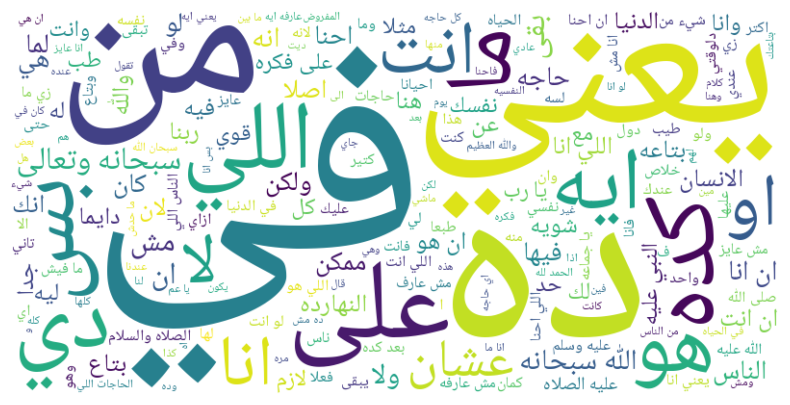

In [23]:
import arabic_reshaper
from bidi.algorithm import get_display  

url = "https://noto-website-2.storage.googleapis.com/pkgs/NotoNaskhArabic-unhinted.zip"
font_zip_path = "NotoNaskhArabic-unhinted.zip"
font_extract_path = "NotoNaskhArabic"

response = requests.get(url)
with open(font_zip_path, "wb") as f:
    f.write(response.content)

with zipfile.ZipFile(font_zip_path, "r") as zip_ref:
    zip_ref.extractall(font_extract_path)

font_path = os.path.join(font_extract_path, "NotoNaskhArabic-Regular.ttf")

reshaped_text = arabic_reshaper.reshape(" ".join(df["clean_transcription"]))
bidi_text = get_display(reshaped_text) 

wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color="white").generate(bidi_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# plt.gca().invert_xaxis()

plt.show()

os.remove(font_zip_path)


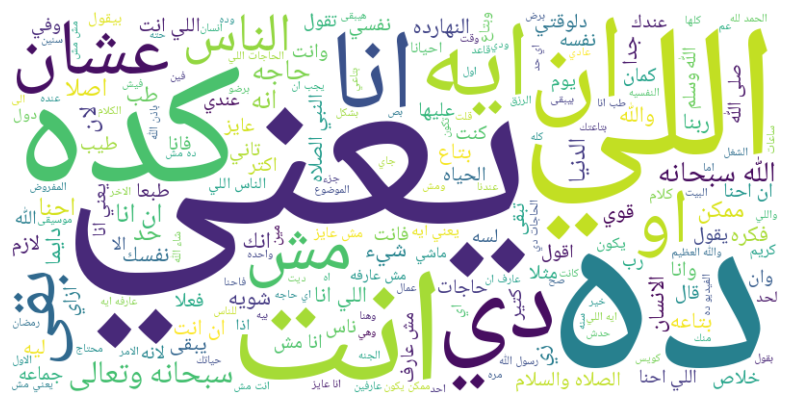

In [24]:
import arabic_reshaper
from bidi.algorithm import get_display  

url = "https://noto-website-2.storage.googleapis.com/pkgs/NotoNaskhArabic-unhinted.zip"
font_zip_path = "NotoNaskhArabic-unhinted.zip"
font_extract_path = "NotoNaskhArabic"

response = requests.get(url)
with open(font_zip_path, "wb") as f:
    f.write(response.content)

with zipfile.ZipFile(font_zip_path, "r") as zip_ref:
    zip_ref.extractall(font_extract_path)

font_path = os.path.join(font_extract_path, "NotoNaskhArabic-Regular.ttf")

reshaped_text = arabic_reshaper.reshape(" ".join(df["nostopwords"]))
bidi_text = get_display(reshaped_text) 

wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color="white").generate(bidi_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# plt.gca().invert_xaxis()

plt.show()

os.remove(font_zip_path)


In [25]:
nltk.download('punkt_tab')

def extract_ngrams(text, n):
    tokens = word_tokenize(text) 
    n_grams = list(ngrams(tokens, n)) 
    return n_grams
all_text = " ".join(df["clean_transcription"])
bigrams = extract_ngrams(all_text, 2)
trigrams = extract_ngrams(all_text, 3)

bigram_counts = Counter(bigrams)
trigram_counts = Counter(trigrams)

print("🔹 Top 10 Bigrams:")
print(bigram_counts.most_common(10))

print("\n🔹 Top 10 Trigrams:")
print(trigram_counts.most_common(10))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\youst\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


🔹 Top 10 Bigrams:
[(('سبحانه', 'وتعالى'), 541), (('الله', 'سبحانه'), 442), (('ان', 'انا'), 401), (('ان', 'انت'), 275), (('ان', 'هو'), 265), (('اللي', 'انا'), 251), (('يا', 'رب'), 200), (('النبي', 'عليه'), 189), (('على', 'فكره'), 184), (('عليه', 'الصلاه'), 183)]

🔹 Top 10 Trigrams:
[(('الله', 'سبحانه', 'وتعالى'), 434), (('عليه', 'الصلاه', 'والسلام'), 180), (('النبي', 'عليه', 'الصلاه'), 153), (('الله', 'عليه', 'وسلم'), 124), (('صلى', 'الله', 'عليه'), 122), (('مش', 'عارفه', 'ايه'), 61), (('سبحانه', 'وتعالى', 'ان'), 55), (('ان', 'شاء', 'الله'), 54), (('من', 'الله', 'سبحانه'), 43), (('ربنا', 'سبحانه', 'وتعالى'), 32)]


C:\Users\youst\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


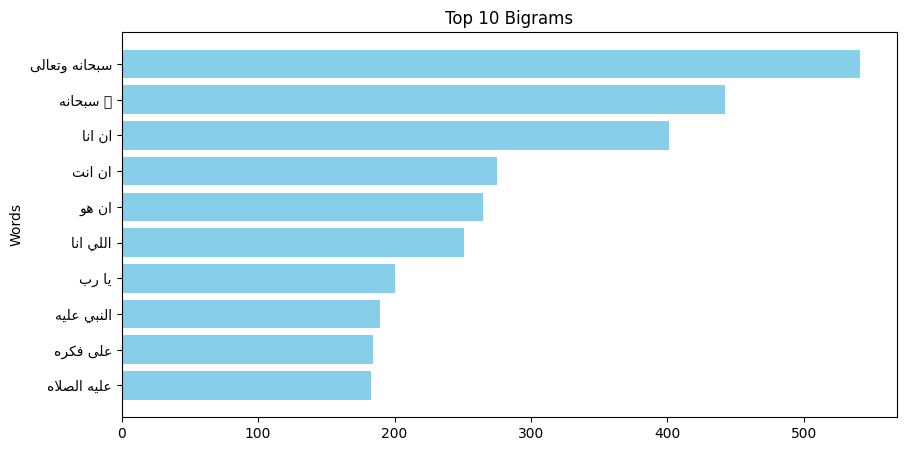

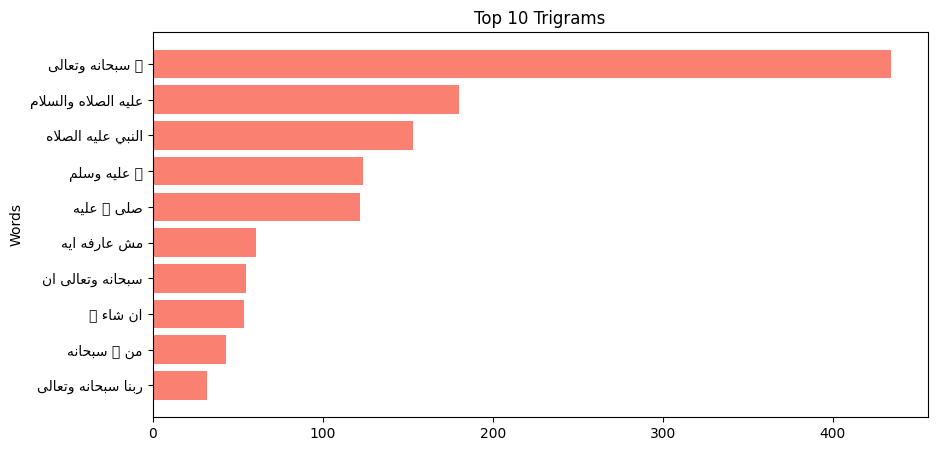

In [26]:
import arabic_reshaper
from bidi.algorithm import get_display  

def reshape_arabic(text_list): 
    return [get_display(arabic_reshaper.reshape(w)) for w in text_list] 

bigram_words = reshape_arabic([" ".join(w) for w, _ in bigram_counts.most_common(10)])
trigram_words = reshape_arabic([" ".join(w) for w, _ in trigram_counts.most_common(10)])

bigram_freqs = [freq for _, freq in bigram_counts.most_common(10)]
trigram_freqs = [freq for _, freq in trigram_counts.most_common(10)]

plt.figure(figsize=(10, 5))
plt.barh(bigram_words, bigram_freqs, color='skyblue')
plt.ylabel("Words")  
plt.title("Top 10 Bigrams")  
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10, 5))
plt.barh(trigram_words, trigram_freqs, color='salmon')
plt.ylabel("Words")  
plt.title("Top 10 Trigrams")  
plt.gca().invert_yaxis()
plt.show()


C:\Users\youst\AppData\Local\Temp\ipykernel_2128\1876722975.py:17: FutureWarning: The provided callable <function mean at 0x00000156631D7880> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  episode_sentiment = df.pivot_table(


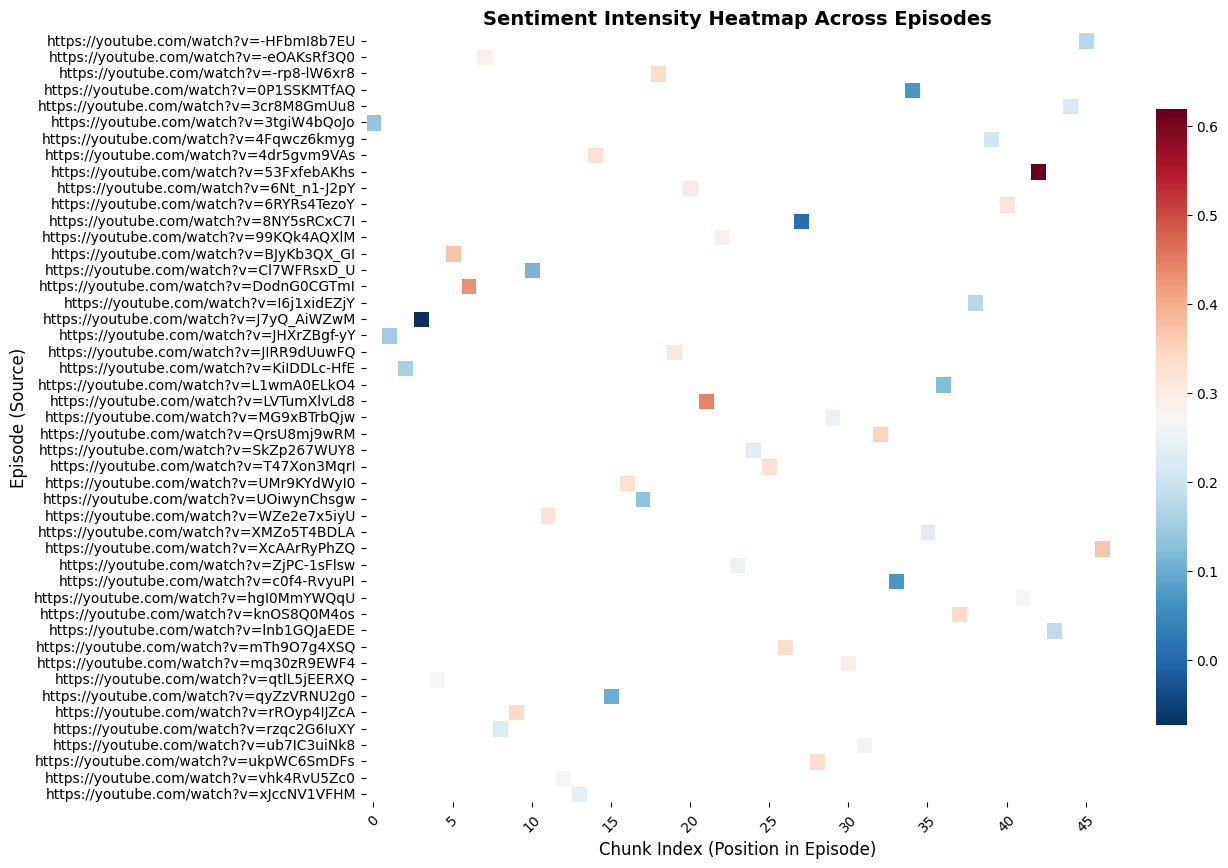

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sentiment_intensity = {
    "Peace": 0.2,        
    "Motivation": 0.7,   
    "Anxiety": -0.6,     
    "Calm": 0.1,         
    "Self-Doubt": -0.8,  
    "Joy": 0.9,          
    "Realism": -0.2      
}

df["sentiment_score"] = df["emotion"].map(sentiment_intensity)

episode_sentiment = df.pivot_table(
    index="source", 
    columns=df.index,  
    values="sentiment_score",  
    aggfunc=np.mean  
)
plt.figure(figsize=(12, 10))  

sns.heatmap(
    episode_sentiment, 
    cmap="RdBu_r", 
    annot=False, 
    linewidths=0.5, 
    cbar=True, 
    cbar_kws={'shrink': 0.8}, 
    xticklabels=5,  
    yticklabels=True 
)

plt.xlabel("Chunk Index (Position in Episode)", fontsize=12)
plt.ylabel("Episode (Source)", fontsize=12)
plt.title("Sentiment Intensity Heatmap Across Episodes", fontsize=14, fontweight="bold")

plt.xticks(rotation=45) 
plt.yticks(fontsize=10)  

plt.show()

In [37]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm  

tokenizer = AutoTokenizer.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment")

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    sentiment = torch.argmax(logits, dim=1).item()
    return sentiment

df["predicted_sentiment_from_model"] = [
    predict_sentiment(text) for text in tqdm(df["chunks"], desc="Processing Sentiments")
]

import ace_tools as tools
tools.display_dataframe_to_user(name="Predicted Sentiments", dataframe=df[["chunks", "predicted_sentiment_from_model"]])


Processing Sentiments: 100%|██████████| 7483/7483 [21:00<00:00,  5.94it/s]  


ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
from IPython.display import display
display(df[["chunks", "predicted_sentiment_from_model"]])

,chunks,predicted_sentiment_from_model
0,كل سنه وانت طيب ورمضان كريم وكل سنه في رمضان ب...,0
0,يكرمنا واحده من اهم النصائح اللي ممكن تفرق معا...,0
0,وما تقعدش تسخن عليا وتقول لي يا كريم دخل الصحه...,2
0,كنت نفسيا منكسر فيها وهمدان ومتضايق ومكسور قو ...,1
0,والذنوب عامله زي ده هو الشيطان لما بيصدق يلاقي...,1
...,...,...
46,الخطيره اللي جت لك وانت بتفرج يا جماعه استخدم ...,2
46,اضافه افضل من المحاضر قالوا فشاركه في التعليقا...,0
46,اللي انا بقوله مثال الحديث ايه فكره علميه معلو...,2
46,قدر المستطاع بس جزاكم الله خير اتمنى ان تكون ا...,0


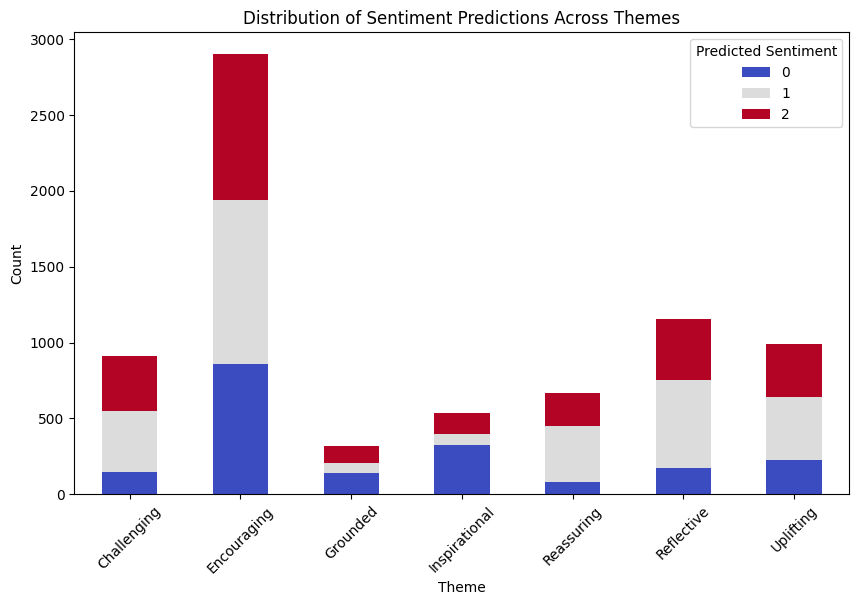

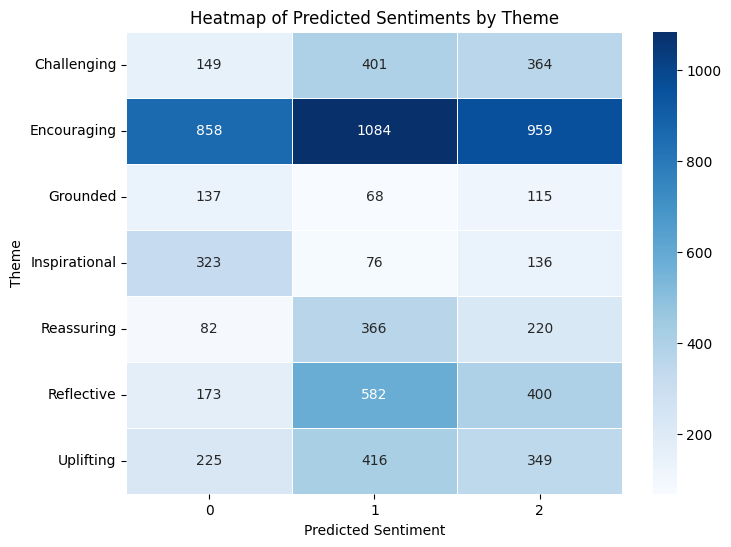

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pivot_df = df.groupby(["theme", "predicted_sentiment_from_model"]).size().unstack(fill_value=0)

pivot_df.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="coolwarm")
plt.xlabel("Theme")
plt.ylabel("Count")
plt.title("Distribution of Sentiment Predictions Across Themes")
plt.legend(title="Predicted Sentiment")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Heatmap of Predicted Sentiments by Theme")
plt.ylabel("Theme")
plt.xlabel("Predicted Sentiment")
plt.show()


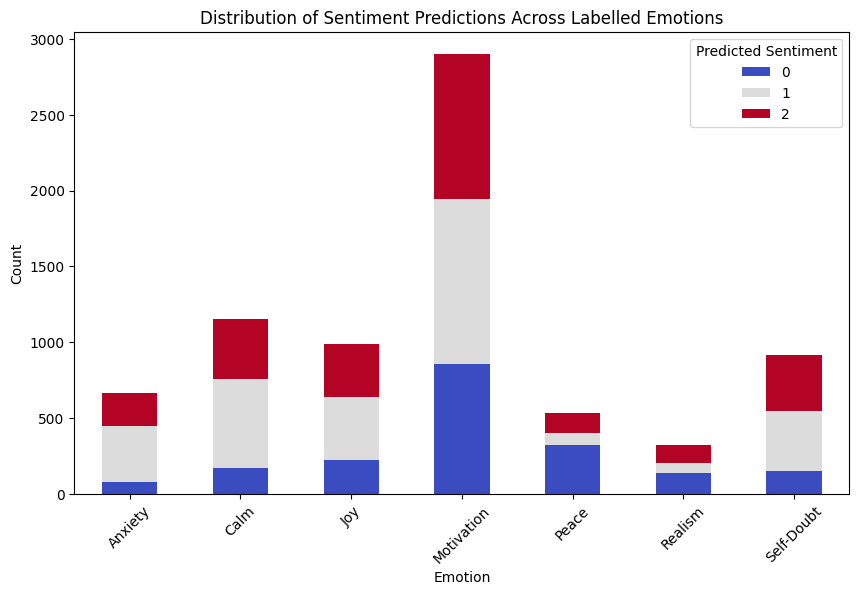

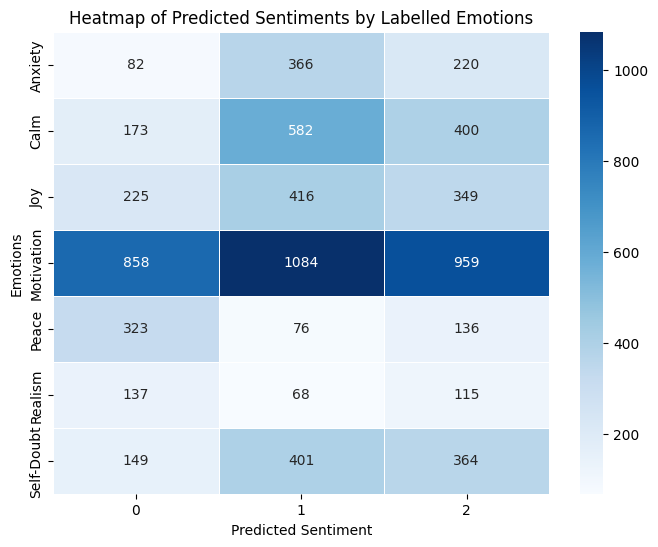

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pivot_df = df.groupby(["emotion", "predicted_sentiment_from_model"]).size().unstack(fill_value=0)

pivot_df.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="coolwarm")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.title("Distribution of Sentiment Predictions Across Labelled Emotions")
plt.legend(title="Predicted Sentiment")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Heatmap of Predicted Sentiments by Labelled Emotions")
plt.ylabel("Emotions")
plt.xlabel("Predicted Sentiment")
plt.show()
